In [2]:
'''
Import of all required libraries
and paths
'''
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import os
%matplotlib inline

os.getcwd()
os.chdir('C:/Users/johan/Python_Projects/Udacity/Project1')

### First Look at the data

In [3]:
'''
Define Sources and take a look at the data
'''
src = "AirBnB_Dataset/"
df = pd.read_csv(src + "listings.csv")

print(df.shape)
df.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


### Data Preparation 

In [5]:
def clean_data(df, dep_var):
    '''
    INPUT
    df - pandas dataframe
    dep_var - name of dependent variable
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no rating
    2. Split up the information given in lists/dictionaries into individual columns
    3. Drop all unnecessary columns
    4. Remove symbols
    5. Filter for a minimum amount of reviews
    6. Translate t/f to boolean
    7. For each numeric variable in df, fill the column nan values with the mean value of the column and normalize
    8. Create dummy columns for all the categorical variables in X, drop the original columns
    9. Create X and y
    '''
    # 1. Drop all the rows with no rating
    df = df.dropna(subset=[dep_var], axis=0)
    
    # 2. Split up the information given in lists/dictionaries into individual columns
    ## Host verification channels
    veris = [x.strip(' ').strip("''") for x in set(df['host_verifications'].str.strip('[]').str.split(',').sum())]
    for veri in veris:
        df['host_verification_'+veri] = df['host_verifications'].str.contains(veri)
    df = df.drop(['host_verifications'], axis=1)
    ## Amenities
    amenities = [x.strip(' ').strip('""') for x in set(df['amenities'].str.strip('{}').str.split(',').sum())]
    for amenity in amenities:
        df['amenities_'+amenity] = df['amenities'].str.contains(amenity)
    df = df.drop(['amenities'], axis=1)  
    
    # 3. Drop all unnecessary columns
    ## Dropping all columns containing URLs
    df = df.drop([col for col in df.columns if 'url' in col], axis=1)
    df = df.drop([col for col in df.columns if 'availability' in col], axis=1)
    ## Dropping all columns with information that is irrelevant, double info, the same for all
    df = df.drop(['amenities_','id', 'scrape_id','name', 'summary', 'space', 'description','license',
                  'smart_location', 'zipcode','neighbourhood','neighborhood_overview',
                  'neighbourhood_cleansed','notes','transit','city',
                 'host_about','host_since','host_name', 'host_location', 'host_neighbourhood',
                  'host_acceptance_rate','host_total_listings_count','street', 
                  'last_scraped', 'calendar_last_scraped', 'first_review','last_review',
                  'requires_license', 'host_verification_reviews', 'amenities_Cat(s)',
                  'amenities_Dog(s)', 'amenities_Other pet(s)'], axis=1)
    
    #Drop all columns with nearly no difference
    for col in list(df):
        if list(df[col].value_counts())[0] > len(df[col])*0.995:
            df = df.drop(col, axis=1)
    
    # 4. Remove symbols
    def remove_symbols(col, symbol, endtype):
        removed = df[col].str.replace(symbol, '').astype(endtype)
        return removed
    
    for rate in ['host_response_rate']:
        df[rate] = remove_symbols(rate, '%', 'float')/100.0

    for price in ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']:
        df[price] = remove_symbols(price, '$', 'string')
        df[price] = remove_symbols(price, ',', 'float')
    
    # 5. Filter for a minimum amount of reviews
    df = df[df['number_of_reviews']>10]
    
    # 6. Translate t/f to boolean
    df = df.replace('t', True)
    df = df.replace('f', False)
    
    # 7. For each numeric variable in df, fill the column nan values with the mean value of the column and normalize
    num_cols = df.select_dtypes(include=['float', 'int']).columns
    for col in num_cols:
        df[col].fillna((df[col].mean()), inplace=True)
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min()) #normalize
        
    # 8. Create dummy columns for all the categorical variables in X, drop the original columns
    cat_cols = df.select_dtypes(include=['object']).copy().columns.difference([dep_var])
    for col in  cat_cols:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    
    # 9. Create X and y
    y = df[dep_var]
    X = df.drop(dep_var, axis=1)
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df, 'review_scores_rating')  

C:\Users\johan\AppData\Local\Temp/ipykernel_20744/4143946613.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['host_verification_'+veri] = df['host_verifications'].str.contains(veri)
C:\Users\johan\AppData\Local\Temp/ipykernel_20744/4143946613.py:34: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['amenities_'+amenity] = df['amenities'].str.contains(amenity)
C:\Users\johan\AppData\Local\Temp/ipykernel_20744/4143946613.py:58: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  removed = df[col].str.replace(symbol, '').astype(endtype)


### Modelling 

#### How positively do customers rate their stay on airBnB? 

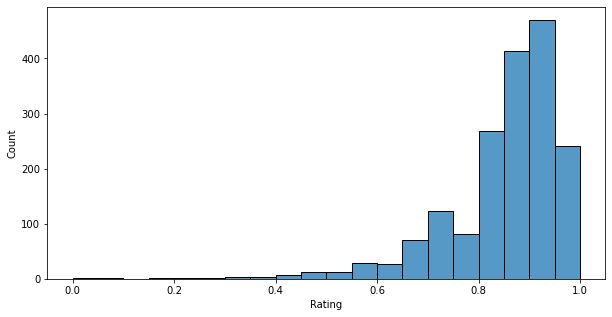

0.8521521440684819


In [6]:
'''
Create a histogram of ratings
'''
df_descriptive = X.copy()
df_descriptive['review_scores_rating']=y

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df_descriptive, x='review_scores_rating', bins = 20);
plt.xlabel('Rating')
plt.show()

print(df_descriptive['review_scores_rating'].mean())